

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
!pip install -U torch torchvision

     |████████████████████████████████| 776.7 MB 3.3 kB/s  eta 0:00:01     |█████▎                          | 128.2 MB 57.8 MB/s eta 0:00:12     |██████▎                         | 153.3 MB 57.8 MB/s eta 0:00:11     |███████                         | 171.1 MB 38.6 MB/s eta 0:00:16     |█████████▊                      | 234.7 MB 39.3 MB/s eta 0:00:14     |██████████████▉                 | 360.0 MB 66.9 MB/s eta 0:00:07     |██████████████████▉             | 456.6 MB 24.9 MB/s eta 0:00:13     |██████████████████▉             | 458.0 MB 24.9 MB/s eta 0:00:13MB/s eta 0:00:13     |███████████████████             | 463.9 MB 24.9 MB/s eta 0:00:13��█▎            | 468.5 MB 24.9 MB/s eta 0:00:13     |███████████████████▋            | 475.2 MB 24.9 MB/s eta 0:00:13MB 46.8 MB/s eta 0:00:06     |█████████████████████▌          | 522.0 MB 6.9 MB/s eta 0:00:38     |████████████████████████▎       | 590.2 MB 41.2 MB/s eta 0:00:05     |████████████████████████▍       | 591.7 MB 11.9 MB/s eta 0:00:16   

In [2]:
# # установка подходящей версии torch

# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

In [3]:
# !pip uninstall wheel -y
# !pip install "wheel==0.34.2"

In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
# !pip uninstall -y Pillow
# !pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

8.0.1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  


In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [5]:
# import os
# os.chdir("gdrive/MyDrive/Colab Notebooks/DLSchool_mipt_1sem/simpsons/")

In [6]:
# os.mkdir("test")

In [7]:
# !unzip -q data/dataset.zip -d train
# !unzip -q data/testset.zip -d test

In [8]:
# !ls train

In [9]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Dec  1 14:56:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [10]:
import pickle
import numpy as np
import pandas as pd
from skimage import io

from sklearn.metrics import f1_score

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision import models, transforms  #, datasets
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [11]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [12]:
# TPU - ???
# DEVICE = xm.xla_device()

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [136]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.labels = None
        if self.mode in ['train', 'val']:
            self.labels = [path.parent.name for path in self.files]
     
        if self.mode == 'train':
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
        else:
            with open('label_encoder.pkl', 'rb') as file:
                self.label_encoder = pickle.load(file)

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train': 
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
#         x = self._prepare_sample(x)
#         x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        train_transforms = transforms.Compose([
#             transforms.RandomResizedCrop(RESCALE_SIZE),
            transforms.RandomHorizontalFlip()
            ])
        
        if self.mode == "train":
            image = train_transforms(image)
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [42]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [43]:
# TRAIN_DIR = Path('train/dataset')
# TEST_DIR = Path('test/testset')

TRAIN_DIR = Path('../input/springfield/dataset/train/simpsons_dataset')
TEST_DIR = Path('../input/springfield/test/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [44]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [45]:
train_dataset = SimpsonsDataset(train_files, mode='train')

In [46]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

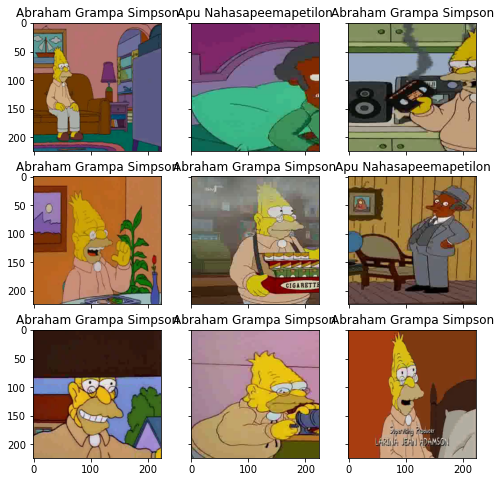

In [47]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [48]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [56]:
def fit_epoch(model, train_loader, criterion, optimizer, verbose=False):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
#     print(f"\ntrain_loader - {len(train_loader)} steps:")
    for num, (inputs, labels) in enumerate(train_loader):
        if verbose:
            print(f"{num} ", end='')

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [57]:
def eval_epoch(model, val_loader, criterion, verbose=False):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

#     print(f"val_loader - {len(val_loader)} steps:")
    for num, (inputs, labels) in enumerate(val_loader):
        if verbose:
            print(f"{num} ", end='')
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [108]:
def train(train_dataset, val_dataset, model, epochs, batch_size, opt=None, scheduler=None, verbose=False):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = opt or torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, verbose)
            print("\nloss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion, verbose)
            history.append((train_loss, train_acc, val_loss, val_acc))
            if scheduler:
                scheduler.step()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [59]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [60]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [62]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

In [63]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64, verbose=False)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]


loss 2.707519117058656


epoch:  50%|█████     | 1/2 [03:10<03:10, 190.22s/it]


Epoch 001 train_loss: 2.7075     val_loss 2.0292 train_acc 0.2463 val_acc 0.4509

loss 1.6499302362786699


epoch: 100%|██████████| 2/2 [05:46<00:00, 173.29s/it]


Epoch 002 train_loss: 1.6499     val_loss 1.3873 train_acc 0.5555 val_acc 0.6297


Построим кривые обучения (завернем построение в функцию, добавим accuracy)

In [77]:
def plot_history(history):
    loss, acc, val_loss, val_acc = zip(*history)
    
    fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
    ax[0].plot(loss, label="train_loss")
    ax[0].plot(val_loss, label="val_loss")
    ax[1].plot(acc, label="train_acc")
    ax[1].plot(val_acc, label="val_acc")
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    ax[0].set_xlabel("epochs")
    ax[1].set_xlabel("epochs")
    ax[0].set_ylabel("loss")
    ax[1].set_ylabel("acc")
    ax[0].set_title("Loss")
    ax[1].set_title("Accuracy")
    plt.show()

In [68]:
# def plot_history(history):
#     loss, acc, val_loss, val_acc = zip(*history)
    
#     plt.figure(figsize=(15, 9))
#     plt.plot(loss, label="train_loss")
#     plt.plot(val_loss, label="val_loss")
#     plt.plot(acc, label="train_acc")
#     plt.plot(val_acc, label="val_acc")
#     plt.legend(loc='best')
#     plt.xlabel("epochs")
#     plt.ylabel("loss / acc")
#     plt.title("history")
#     plt.show()

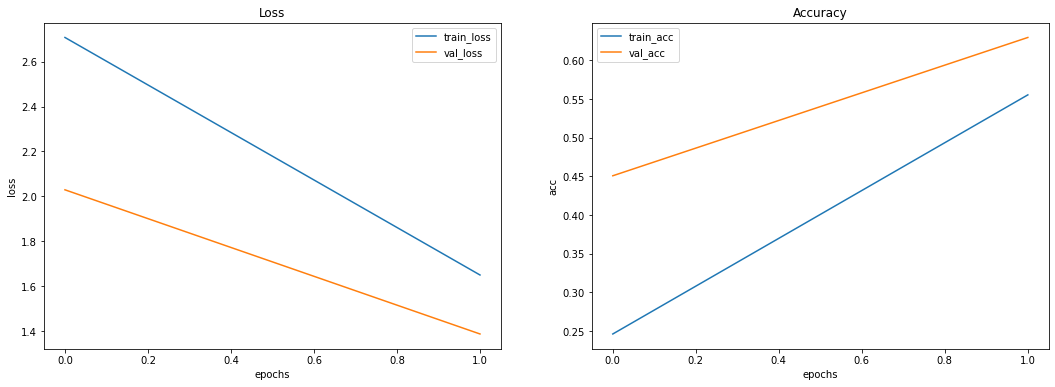

In [78]:
plot_history(history)

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [79]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

завернем подсчет **f1** для удобства в одну функцию

In [80]:
def val_f1_score(val_dataset, model, label_encoder=None):
    label_encoder = label_encoder or pickle.load(open("label_encoder.pkl", 'rb'))

    random_characters = int(np.random.uniform(0,1000))
    ex_img, true_label = val_dataset[random_characters]
    probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

    idxs = list(map(int, np.random.uniform(0,1000, 20)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)

    y_pred = np.argmax(probs_ims,-1)

    # actual_labels = [val_dataset[id][1] for id in idxs]
    actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]

    preds_class = [label_encoder.classes_[i] for i in y_pred]

    return f1_score(actual_labels, preds_class, average='micro')

In [84]:
val_f1_score(val_dataset, simple_cnn)

0.6

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [88]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

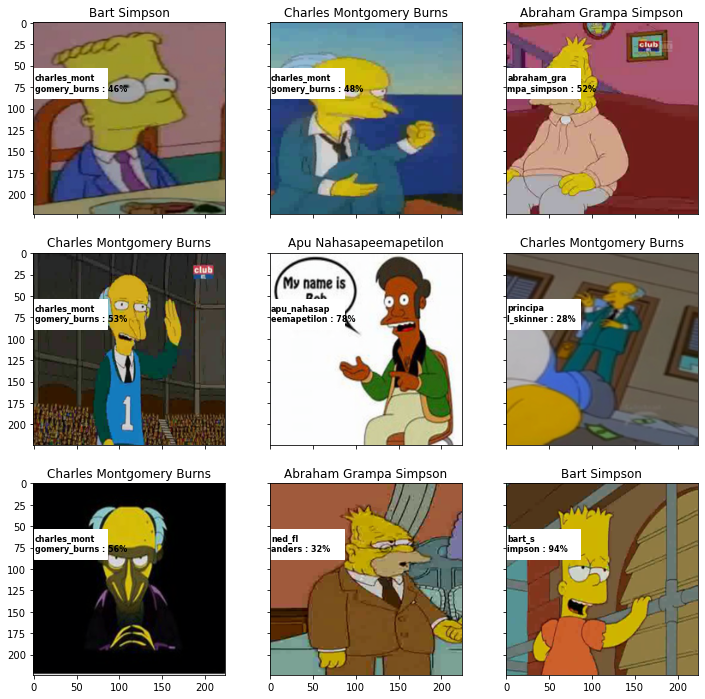

In [89]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [90]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [91]:
! ls 

__notebook_source__.ipynb  label_encoder.pkl


In [92]:
# my_submit = pd.read_csv("gdrive/MyDrive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# sample_submission = pd.read_csv("sample_submission.csv")
# my_submit = pd.merge(sample_submission.drop("Expected", axis=1), my_submit)
# my_submit.head()

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

#### соберем подготовку submit в функцию

In [93]:
def get_save_submit(test_files, model, sub_file_name):    
    test_dataset = SimpsonsDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
    probs = predict(model, test_loader)


    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    test_filenames = [path.name for path in test_dataset.files]

    my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

#     sample_submission = pd.read_csv("sample_submission.csv")
#     my_submit = pd.merge(sample_submission.drop("Expected", axis=1), my_submit)

    my_submit.to_csv(sub_file_name, index=False)
    return my_submit

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


## <center>Доработка сети

### ResNet

А)

In [94]:
models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [107]:
model_extractor = models.resnet18(pretrained=True).to(DEVICE)

# замораживаем параметры (веса)
# for param in model_extractor.parameters():
#     param.requires_grad = False

ct = 0
for child in model_extractor.children():
    ct += 1
    if ct < 6:
        for param in child.parameters():
            param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.fc = nn.Linear(num_features, n_classes).to(DEVICE)

# Обучаем только классификатор
optimizer = torch.optim.Adam(model_extractor.fc.parameters(), lr=1e-3)

In [96]:
history = train(train_dataset, val_dataset, model=model_extractor, epochs=10, batch_size=64, opt=optimizer, verbose=False)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


loss 2.127039761837595


epoch:  10%|█         | 1/10 [02:44<24:37, 164.17s/it]


Epoch 001 train_loss: 2.1270     val_loss 1.5453 train_acc 0.4836 val_acc 0.6370

loss 1.2951269225562725


epoch:  20%|██        | 2/10 [05:28<21:53, 164.24s/it]


Epoch 002 train_loss: 1.2951     val_loss 1.1981 train_acc 0.6837 val_acc 0.6983

loss 1.052217452167227


epoch:  30%|███       | 3/10 [08:15<19:15, 165.14s/it]


Epoch 003 train_loss: 1.0522     val_loss 1.0766 train_acc 0.7339 val_acc 0.7306

loss 0.9247470478759737


epoch:  40%|████      | 4/10 [11:04<16:36, 166.07s/it]


Epoch 004 train_loss: 0.9247     val_loss 0.9946 train_acc 0.7598 val_acc 0.7390

loss 0.8518430271971202


epoch:  50%|█████     | 5/10 [13:52<13:53, 166.72s/it]


Epoch 005 train_loss: 0.8518     val_loss 0.9556 train_acc 0.7753 val_acc 0.7482

loss 0.7887353388258845


epoch:  60%|██████    | 6/10 [16:40<11:08, 167.05s/it]


Epoch 006 train_loss: 0.7887     val_loss 0.9232 train_acc 0.7890 val_acc 0.7499

loss 0.7483462748941218


epoch:  70%|███████   | 7/10 [19:29<08:23, 167.68s/it]


Epoch 007 train_loss: 0.7483     val_loss 0.8872 train_acc 0.7974 val_acc 0.7640

loss 0.7185337999852814


epoch:  80%|████████  | 8/10 [22:17<05:35, 167.85s/it]


Epoch 008 train_loss: 0.7185     val_loss 0.8855 train_acc 0.8046 val_acc 0.7669

loss 0.6941956760959418


epoch:  90%|█████████ | 9/10 [25:05<02:47, 167.88s/it]


Epoch 009 train_loss: 0.6942     val_loss 0.8872 train_acc 0.8108 val_acc 0.7618

loss 0.6655727790771712


epoch: 100%|██████████| 10/10 [27:53<00:00, 167.40s/it]


Epoch 010 train_loss: 0.6656     val_loss 0.8827 train_acc 0.8155 val_acc 0.7614


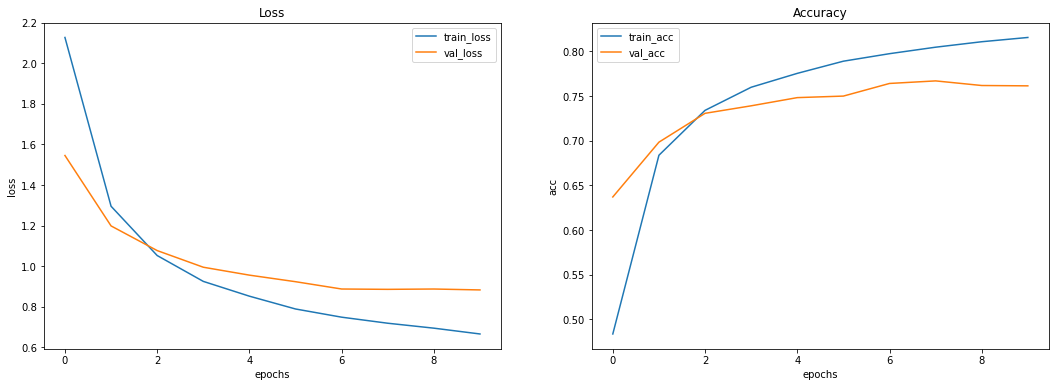

In [97]:
plot_history(history)

#### проверяем f1 score

In [105]:
val_f1_score(val_dataset, model_extractor)

0.85

In [106]:
get_save_submit(test_files, model_extractor, 'resnet_model_extractor_3.csv').head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,lisa_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


Б)

In [112]:
model_extractor = models.resnet18(pretrained=True).to(DEVICE)

# замораживаем параметры (веса)
# for param in model_extractor.parameters():
#     param.requires_grad = False

ct = 0
for child in model_extractor.children():
    ct += 1
    if ct < 4:
        for param in child.parameters():
            param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.fc = nn.Linear(num_features, n_classes).to(DEVICE)

# Обучаем только классификатор
optimizer = torch.optim.Adam(model_extractor.fc.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)

In [113]:
history = train(train_dataset, val_dataset, model=model_extractor, epochs=10, 
                batch_size=64, opt=optimizer, scheduler=scheduler, verbose=False)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


loss 2.1342189267407754


epoch:  10%|█         | 1/10 [02:52<25:54, 172.69s/it]


Epoch 001 train_loss: 2.1342     val_loss 1.5224 train_acc 0.4824 val_acc 0.6544

loss 1.2925731530272435


epoch:  20%|██        | 2/10 [05:45<23:01, 172.66s/it]


Epoch 002 train_loss: 1.2926     val_loss 1.2048 train_acc 0.6893 val_acc 0.6941

loss 1.0742139119662724


epoch:  30%|███       | 3/10 [08:38<20:09, 172.77s/it]


Epoch 003 train_loss: 1.0742     val_loss 1.1547 train_acc 0.7350 val_acc 0.7128

loss 1.0535166220943202


epoch:  40%|████      | 4/10 [11:30<17:15, 172.55s/it]


Epoch 004 train_loss: 1.0535     val_loss 1.1371 train_acc 0.7411 val_acc 0.7136

loss 1.0361759725425856


epoch:  50%|█████     | 5/10 [14:21<14:20, 172.07s/it]


Epoch 005 train_loss: 1.0362     val_loss 1.1334 train_acc 0.7432 val_acc 0.7147

loss 1.031741957139328


epoch:  60%|██████    | 6/10 [17:12<11:27, 171.87s/it]


Epoch 006 train_loss: 1.0317     val_loss 1.1313 train_acc 0.7452 val_acc 0.7151

loss 1.0325082714401679


epoch:  70%|███████   | 7/10 [20:01<08:33, 171.01s/it]


Epoch 007 train_loss: 1.0325     val_loss 1.1311 train_acc 0.7466 val_acc 0.7153

loss 1.030654178268477


epoch:  80%|████████  | 8/10 [22:50<05:40, 170.42s/it]


Epoch 008 train_loss: 1.0307     val_loss 1.1308 train_acc 0.7488 val_acc 0.7151

loss 1.0333025034343113


epoch:  90%|█████████ | 9/10 [25:39<02:50, 170.06s/it]


Epoch 009 train_loss: 1.0333     val_loss 1.1308 train_acc 0.7432 val_acc 0.7151

loss 1.027303163834731


epoch: 100%|██████████| 10/10 [28:28<00:00, 170.89s/it]


Epoch 010 train_loss: 1.0273     val_loss 1.1308 train_acc 0.7456 val_acc 0.7151


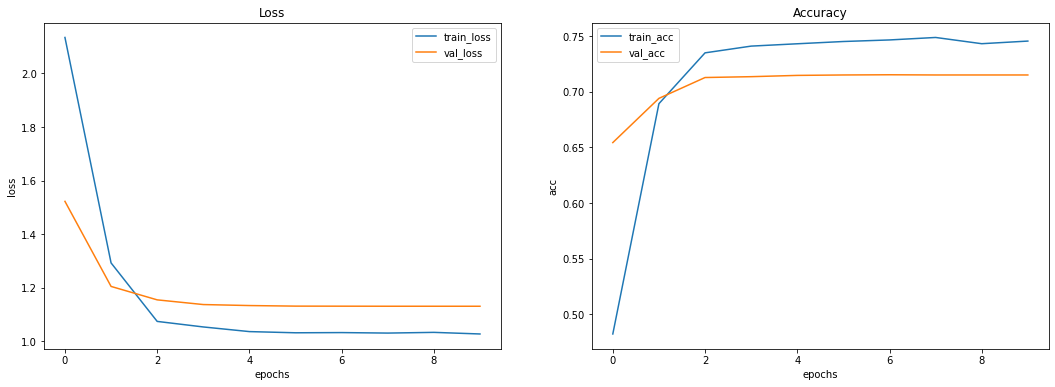

In [114]:
plot_history(history)

In [115]:
val_f1_score(val_dataset, model_extractor)

0.65

In [116]:
get_save_submit(test_files, model_extractor, 'resnet_model_extractor_4.csv').head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,lisa_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


В)

In [117]:
models.resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [127]:
model_extractor = models.resnet18(pretrained=True).to(DEVICE)

# замораживаем параметры (веса)
# for param in model_extractor.parameters():
#     param.requires_grad = False

ct = 0
for child in model_extractor.children():
    ct += 1
    if ct < 3:
        for param in child.parameters():
            param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.fc = nn.Linear(num_features, n_classes).to(DEVICE)

# Обучаем только классификатор
optimizer = torch.optim.Adadelta(model_extractor.fc.parameters())
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)

In [128]:
history = train(train_dataset, val_dataset, model=model_extractor, epochs=10, 
                batch_size=64, opt=optimizer, scheduler=None, verbose=False)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


loss 1.9593978686441744


epoch:  10%|█         | 1/10 [02:50<25:32, 170.24s/it]


Epoch 001 train_loss: 1.9594     val_loss 1.5445 train_acc 0.4917 val_acc 0.5709

loss 1.1422289919265478


epoch:  20%|██        | 2/10 [05:39<22:40, 170.08s/it]


Epoch 002 train_loss: 1.1422     val_loss 1.2893 train_acc 0.6958 val_acc 0.6372

loss 0.9504081659601314


epoch:  30%|███       | 3/10 [08:29<19:48, 169.81s/it]


Epoch 003 train_loss: 0.9504     val_loss 1.1970 train_acc 0.7396 val_acc 0.6634

loss 0.8494013082495889


epoch:  40%|████      | 4/10 [11:18<16:57, 169.55s/it]


Epoch 004 train_loss: 0.8494     val_loss 1.2022 train_acc 0.7614 val_acc 0.6553

loss 0.790493390588094


epoch:  50%|█████     | 5/10 [14:05<14:04, 168.94s/it]


Epoch 005 train_loss: 0.7905     val_loss 1.0700 train_acc 0.7743 val_acc 0.7052

loss 0.7456857428914294


epoch:  60%|██████    | 6/10 [16:57<11:19, 169.93s/it]


Epoch 006 train_loss: 0.7457     val_loss 1.1316 train_acc 0.7911 val_acc 0.6970

loss 0.7129556531472998


epoch:  70%|███████   | 7/10 [19:50<08:32, 170.72s/it]


Epoch 007 train_loss: 0.7130     val_loss 1.0367 train_acc 0.7978 val_acc 0.7169

loss 0.6836597767785306


epoch:  80%|████████  | 8/10 [22:42<05:42, 171.07s/it]


Epoch 008 train_loss: 0.6837     val_loss 1.1194 train_acc 0.8051 val_acc 0.6934

loss 0.6533823556539792


epoch:  90%|█████████ | 9/10 [25:35<02:51, 171.71s/it]


Epoch 009 train_loss: 0.6534     val_loss 0.8974 train_acc 0.8097 val_acc 0.7570

loss 0.6475885888825359


epoch: 100%|██████████| 10/10 [28:27<00:00, 170.70s/it]


Epoch 010 train_loss: 0.6476     val_loss 0.9886 train_acc 0.8118 val_acc 0.7388


In [133]:
val_f1_score(val_dataset, model_extractor)

0.7

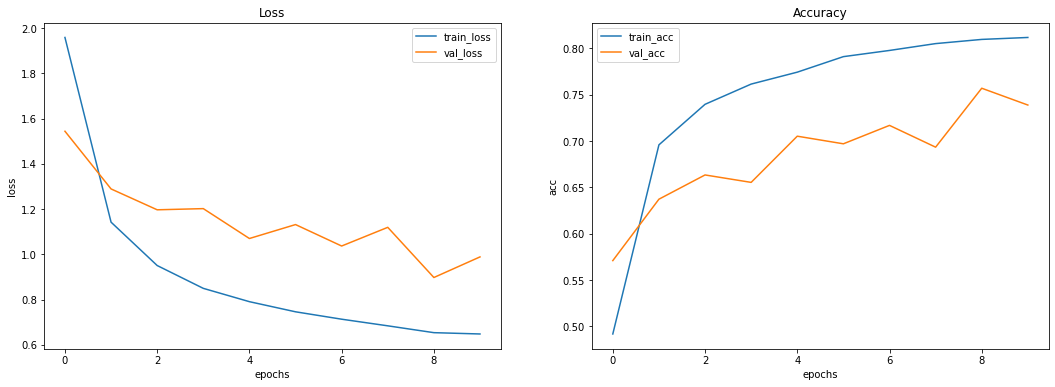

In [134]:
plot_history(history)

In [135]:
get_save_submit(test_files, model_extractor, 'resnet_model_extractor_5.csv').head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,lisa_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


Г)

In [138]:
model_extractor = models.resnet18(pretrained=True).to(DEVICE)

# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# ct = 0
# for child in model_extractor.children():
#     ct += 1
#     if ct < 3:
#         for param in child.parameters():
#             param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.fc = nn.Linear(num_features, n_classes).to(DEVICE)

# Обучаем только классификатор
optimizer = torch.optim.Adadelta(model_extractor.fc.parameters())
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)

In [139]:
history = train(train_dataset, val_dataset, model=model_extractor, epochs=5, 
                batch_size=64, opt=optimizer, scheduler=None, verbose=False)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]


loss 1.9146341041771726


epoch:  20%|██        | 1/5 [02:44<10:58, 164.61s/it]


Epoch 001 train_loss: 1.9146     val_loss 1.4388 train_acc 0.5026 val_acc 0.6152

loss 1.133282819123198


epoch:  40%|████      | 2/5 [05:28<08:13, 164.36s/it]


Epoch 002 train_loss: 1.1333     val_loss 1.2875 train_acc 0.6952 val_acc 0.6536

loss 0.9449494231680455


epoch:  60%|██████    | 3/5 [08:10<05:27, 163.79s/it]


Epoch 003 train_loss: 0.9449     val_loss 1.0394 train_acc 0.7417 val_acc 0.7134

loss 0.8567423306211437


epoch:  80%|████████  | 4/5 [10:52<02:43, 163.21s/it]


Epoch 004 train_loss: 0.8567     val_loss 1.0178 train_acc 0.7576 val_acc 0.7149

loss 0.7853890783399964


epoch: 100%|██████████| 5/5 [13:33<00:00, 162.76s/it]


Epoch 005 train_loss: 0.7854     val_loss 1.0685 train_acc 0.7793 val_acc 0.7126


включим все слои

In [140]:
for param in model_extractor.parameters():
    param.requires_grad = True

In [ ]:
history = train(train_dataset, val_dataset, model=model_extractor, epochs=25, 
                batch_size=64, opt=optimizer, scheduler=None, verbose=False)